In [1]:
## Read EOS projection
import pandas as pd
start_year = 2026
end_year = 2101
def read_eos_projection(ssp):
    eos_projection1 = pd.read_pickle(f"../model/data/tables/params/{ssp}/eos_projection_0000_1600.pkl")
    eos_projection2 = pd.read_pickle(f"../model/data/tables/params/{ssp}/eos_projection_1600_3200.pkl")
    eos_projection = eos_projection1 + eos_projection2
    return eos_projection

In [ ]:
## Filter out 365
import numpy as np

def filter_data_by_coordinates(data):
    # Collect all unique coordinate pairs (latitude, longitude)
    coordinates = set((d["latitude"], d["longitude"]) for d in data)
    bad_coordinates = set()

    for coord in coordinates:
        # Collect all models for the current coordinate
        models_for_coord = [d for d in data if (d["latitude"], d["longitude"]) == coord]

        for m in models_for_coord:
            # Check condition for bad pixels
            if np.all(m["predicted_eos"] == 365):
                bad_coordinates.add(coord)
                break

    # Filter out entries with bad coordinates
    return [d for d in data if (d["latitude"], d["longitude"]) not in bad_coordinates]

In [ ]:
## Plot EOS trend
def plot_eos_trend(all_predictions, start_year, end_year):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # === Prepare years ===
    years = np.arange(start_year, end_year)
    
    # === Create DataFrame from predictions ===
    df_preds = pd.DataFrame({
        'latitude': [p['latitude'] for p in all_predictions],
        'longitude': [p['longitude'] for p in all_predictions],
        'model': [p['model'] for p in all_predictions],
        'eos': [p['predicted_eos'] for p in all_predictions]
    })
    
    # === Color mapping: brighter colors ===
    model_colors = {
        'CDD': '#A3D4E0',         # Brighter Light Blue
        'DM': '#5BAED8',         # Bright Medium Blue
        'SIAM': '#3B83C4',        # Bright Blue
    
        'SIAMN': '#EA9E88',  # Bright Light Red (Coral)
        'SIAMNP': '#D1837D' # Bright Red (Carmine)
    }
    
    # Set desired order for subplot bars
    models_order = ['CDD', 'DM', 'SIAM', 'SIAMN', 'SIAMNP']
    
    # === Create main figure ===
    fig, ax_main = plt.subplots(figsize=(6, 5))
    
    models = df_preds['model'].unique()
    
    for model in models:
        model_rows = df_preds[df_preds['model'] == model]
    
        # Stack EOS values: shape = (n_coordinates, n_years)
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Compute mean and std across coordinates
        eos_mean = eos_df_model.mean(axis=0)
        eos_std = eos_df_model.std(axis=0)
    
        # Apply 15-year rolling window smoothing
        mean_smooth = eos_mean.rolling(window=1, center=True, min_periods=1).mean()
        std_smooth = eos_std.rolling(window=1, center=True, min_periods=1).mean()
    
        # Get color for the model
        color = model_colors.get(model, 'black')  # default to black if model is not in dictionary
    
        # Plot smoothed mean line
        ax_main.plot(years, mean_smooth, label=model, color=color, linewidth=2)
    
        # Plot ±0.5, standard deviation shaded region
        ax_main.fill_between(years,
                         mean_smooth - std_smooth/4,  # std should modify mean
                         mean_smooth + std_smooth/4,
                         color='lightgray',
                         alpha=0.2)
    
    # Main plot labels and limits
    ax_main.set_xlabel('Year', fontsize=14)
    ax_main.set_ylabel('EOS (DOY)', fontsize=14)
    ax_main.set_xlim(2026, 2100)
    ax_main.tick_params(axis='x', labelsize=12)
    ax_main.tick_params(axis='y', labelsize=12)
    ax_main.set_ylim(265, 345)

    # === Inset: EOS difference bar plot with error bars ===
    ax_inset = ax_main.inset_axes([0.13, 0.7, 0.3, 0.25])  # [x0, y0, width, height]
    
    # Compute difference per coordinate and calculate mean & half std as error bar
    diff_means = []
    diff_errors = []
    
    for model in models_order:
        model_rows = df_preds[df_preds['model'] == model]
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Mean EOS for first 5 years and last 5 years per coordinate (axis=1)
        first_10 = eos_df_model.loc[:, start_year:start_year+5].mean(axis=1)
        last_10 = eos_df_model.loc[:, end_year-5:end_year].mean(axis=1)
    
        # Difference per coordinate
        diff_per_coordinate = last_10 - first_10
    
        # Mean and half std deviation for error bar
        diff_means.append(diff_per_coordinate.mean())
        diff_errors.append(0.25 * diff_per_coordinate.std())  # Updated to calculate std properly
    
    colors_ordered = [model_colors.get(m, 'gray') for m in models_order]
    
    # Bar plot with error bars
    bars = ax_inset.bar(np.arange(len(models_order)), diff_means, 
                        yerr=diff_errors, capsize=5,
                        color=colors_ordered)
    print("EOS delays by 2100", diff_means)
    # Set proper xticks and labels
    ax_inset.set_xticks(np.arange(len(models_order)))
    ax_inset.set_xticklabels(models_order, rotation=45, ha='right', fontsize=10)
    
    # Labels and title for inset
    ax_inset.set_ylabel('EOS delay (days)', fontsize=10)
    ax_inset.tick_params(axis='both', labelsize=8)
    ax_inset.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_inset.tick_params(axis='x', labelsize=10)
    ax_inset.tick_params(axis='y', labelsize=10)
    ax_inset.set_ylim(0, 55)

    # Adjust layout, avoid tight_layout because of inset
    plt.subplots_adjust(right=0.95, bottom=0.15)
    return fig


In [4]:
## Get EOS projections under SSP245 and SSP585
eos_projection_ssp245 = read_eos_projection('ssp245')
eos_projection_ssp585 = read_eos_projection('ssp585')

In [5]:
## Plot EOS projection in three regions

In [6]:
# Function to snap to nearest latitude and longitude
def snap_to_array(values, ref_array):
    idx = np.abs(values[:, None] - ref_array).argmin(axis=1)
    return ref_array[idx]

latitude = np.array([30.62827225, 31.57068063, 32.51308901, 33.45549738, 34.39790576, 35.34031414,
 36.28272251, 37.22513089, 38.16753927, 39.10994764, 40.05235602, 40.9947644,
 41.93717277, 42.87958115, 43.82198953, 44.76439791, 45.70680628, 46.64921466,
 47.59162304, 48.53403141, 49.47643979, 50.41884817, 51.36125654, 52.30366492,
 53.2460733,  54.18848168, 55.13089005, 56.07329843, 57.01570681, 57.95811518,
 58.90052356, 59.84293194, 60.78534031, 61.72774869, 62.67015707, 63.61256545,
 64.55497382, 65.4973822,  66.43979058, 67.38219895, 68.32460733, 69.26701571,
 70.20942408, 71.15183246, 72.09424084, 73.03664921, 73.97905759, 74.92146597,
 75.86387435, 76.80628272, 77.7486911,  78.69109948, 79.63350785, 80.57591623,
 81.51832461, 82.46073298, 83.40314136, 84.34554974, 85.28795812, 86.23036649,
 87.17277487, 88.11518325, 89.05759162, 90.
])
longitude = np.array([  0.,     1.25,   2.5,    3.75,   5.,     6.25,   7.5,    8.75,  10.,    11.25,
  12.5,   13.75,  15.,    16.25,  17.5,   18.75,  20.,    21.25,  22.5,   23.75,
  25.,    26.25,  27.5,   28.75,  30.,    31.25,  32.5,   33.75,  35.,    36.25,
  37.5,   38.75,  40.,    41.25,  42.5,   43.75,  45.,    46.25,  47.5,   48.75,
  50.,    51.25,  52.5,   53.75,  55.,    56.25,  57.5,   58.75,  60.,    61.25,
  62.5,   63.75,  65.,    66.25,  67.5,   68.75,  70.,    71.25,  72.5,   73.75,
  75.,    76.25,  77.5,   78.75,  80.,    81.25,  82.5,   83.75,  85.,    86.25,
  87.5,   88.75,  90.,    91.25,  92.5,   93.75,  95.,    96.25,  97.5,   98.75,
 100.,   101.25, 102.5,  103.75, 105.,   106.25, 107.5,  108.75, 110.,   111.25,
 112.5,  113.75, 115.,   116.25, 117.5,  118.75, 120.,   121.25, 122.5,  123.75,
 125.,   126.25, 127.5,  128.75, 130.,   131.25, 132.5,  133.75, 135.,   136.25,
 137.5,  138.75, 140.,   141.25, 142.5,  143.75, 145.,   146.25, 147.5,  148.75,
 150.,   151.25, 152.5,  153.75, 155.,   156.25, 157.5,  158.75, 160.,   161.25,
 162.5,  163.75, 165.,   166.25, 167.5,  168.75, 170.,   171.25, 172.5,  173.75,
 175.,   176.25, 177.5,  178.75, 180.,   181.25, 182.5,  183.75, 185.,   186.25,
 187.5,  188.75, 190.,   191.25, 192.5,  193.75, 195.,   196.25, 197.5,  198.75,
 200.,   201.25, 202.5,  203.75, 205.,   206.25, 207.5,  208.75, 210.,   211.25,
 212.5,  213.75, 215.,   216.25, 217.5,  218.75, 220.,   221.25, 222.5,  223.75,
 225.,   226.25, 227.5,  228.75, 230.,   231.25, 232.5,  233.75, 235.,   236.25,
 237.5,  238.75, 240.,   241.25, 242.5,  243.75, 245.,   246.25, 247.5,  248.75,
 250.,   251.25, 252.5,  253.75, 255.,   256.25, 257.5,  258.75, 260.,   261.25,
 262.5,  263.75, 265.,   266.25, 267.5,  268.75, 270.,   271.25, 272.5,  273.75,
 275.,   276.25, 277.5,  278.75, 280.,   281.25, 282.5,  283.75, 285.,   286.25,
 287.5,  288.75, 290.,   291.25, 292.5,  293.75, 295.,   296.25, 297.5,  298.75,
 300.,   301.25, 302.5,  303.75, 305.,   306.25, 307.5,  308.75, 310.,   311.25,
 312.5,  313.75, 315.,   316.25, 317.5,  318.75, 320.,   321.25, 322.5,  323.75,
 325.,   326.25, 327.5,  328.75, 330.,   331.25, 332.5,  333.75, 335.,   336.25,
 337.5,  338.75, 340.,   341.25, 342.5,  343.75, 345.,   346.25, 347.5,  348.75,
 350.,   351.25, 352.5,  353.75, 355.,   356.25, 357.5,  358.75])
longitude = longitude - 180


In [7]:
## Keep 4th decimal for lat and lon
def aggregate_pixel(df):
    df["latitude"] = snap_to_array(df["latitude"].values, latitude)
    df["longitude"] = snap_to_array(df["longitude"].values, longitude)
    df = df.groupby(["latitude", "longitude"], as_index=False).mean()
    df["latitude"] = df["latitude"].round(4)
    df["longitude"] = df["longitude"].round(4)
    return df

In [8]:
## Read files and data clean
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/satellite_data/tables/veg_class/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

def read_pep725(mini_years):
    df = pd.read_csv('../PEP725 Code/data/tables/pep725.csv')
    df = filter_year(df, mini_years)
    return df

import re

def filter_year(df, mini_years):
    predictor_names = ['spring_t', 'summer_t', 'autumn_t', 'annual_t', 'spring_p', 'summer_p', 'autumn_p', 'sos', 'eos']

    def is_valid_predictor_column(col):
        for pred in predictor_names:
            if col.startswith(pred + "_"):
                match = re.search(r'_(\d{4})$', col)
                if match:
                    year = int(match.group(1))
                    return 1950 <= year <= 2015
        return False

    # Keep only the relevant columns
    columns_to_keep = [
        col for col in df.columns
        if is_valid_predictor_column(col) or all(not col.startswith(pred + "_") for pred in predictor_names)
    ]
    
    df_filtered = df[columns_to_keep]

    # Identify valid eos columns in the filtered dataframe
    eos_columns = [
        col for col in df_filtered.columns
        if col.startswith('eos_') and re.search(r'_(\d{4})$', col)
    ]

    # Count non-null eos values per row and keep rows with at least 40 valid values
    df_filtered = df_filtered[df_filtered[eos_columns].notna().sum(axis=1) >= mini_years]

    return df_filtered


In [9]:
## Read AVHRR data and aggregate AVHRR to EOS projection grids
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df = df[['annual_t', 'annual_p', 'latitude', 'longitude']]
df = aggregate_pixel(df)

In [10]:
## Merge temperature (annual_t) and precipitation (annual_p) data into a list of EOS projection
def merge_t_p(eos_projection):
    
    data_list = eos_projection
    # Create a lookup dictionary from df
    lookup = df.set_index(['latitude', 'longitude']).to_dict(orient='index')
    
    # Loop through list and assign values
    for entry in data_list:
        lat, lon = entry['latitude'], entry['longitude']
        if (lat, lon) in lookup:
            entry['annual_t'] = lookup[(lat, lon)]['annual_t']
            entry['annual_p'] = lookup[(lat, lon)]['annual_p']
        else:
            entry['annual_t'] = None  # or np.nan
            entry['annual_p'] = None
    
    return data_list

In [11]:
## Plot EOS trend
def plot_eos_trend(all_predictions, start_year, end_year):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # === Prepare years ===
    years = np.arange(start_year, end_year)
    
    # === Create DataFrame from predictions ===
    df_preds = pd.DataFrame({
        'latitude': [p['latitude'] for p in all_predictions],
        'longitude': [p['longitude'] for p in all_predictions],
        'model': [p['model'] for p in all_predictions],
        'eos': [p['predicted_eos'] for p in all_predictions]
    })
    
    # === Color mapping: brighter colors ===
    model_colors = {
        'CDD': '#A3D4E0',         # Brighter Light Blue
        'DM': '#5BAED8',         # Bright Medium Blue
        'SIAM': '#3B83C4',        # Bright Blue
    
        'SIAMN': '#EA9E88',  # Bright Light Red (Coral)
        'SIAMNP': '#D1837D' # Bright Red (Carmine)
    }
    
    # Set desired order for subplot bars
    models_order = ['CDD', 'DM', 'SIAM', 'SIAMN', 'SIAMNP']
    
    # === Create main figure ===
    fig, ax_main = plt.subplots(figsize=(6, 5))
    
    models = df_preds['model'].unique()
    
    for model in models:
        model_rows = df_preds[df_preds['model'] == model]
    
        # Stack EOS values: shape = (n_coordinates, n_years)
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Compute mean and std across coordinates
        eos_mean = eos_df_model.mean(axis=0)
        eos_std = eos_df_model.std(axis=0)
    
        # Apply 15-year rolling window smoothing
        mean_smooth = eos_mean.rolling(window=1, center=True, min_periods=1).mean()
        std_smooth = eos_std.rolling(window=1, center=True, min_periods=1).mean()
    
        # Get color for the model
        color = model_colors.get(model, 'black')  # default to black if model is not in dictionary
    
        # Plot smoothed mean line
        ax_main.plot(years, mean_smooth, label=model, color=color, linewidth=2)
    
        # Plot ±0.5, standard deviation shaded region
        ax_main.fill_between(years,
                         mean_smooth - std_smooth/4,  # std should modify mean
                         mean_smooth + std_smooth/4,
                         color='lightgray',
                         alpha=0.2)
    
    # Main plot labels and limits
    ax_main.set_xlabel('Year', fontsize=14)
    ax_main.set_ylabel('EOS (DOY)', fontsize=14)
    ax_main.set_xlim(2026, 2100)
    ax_main.tick_params(axis='x', labelsize=12)
    ax_main.tick_params(axis='y', labelsize=12)
    ax_main.set_ylim(260, 365)

    # === Inset: EOS difference bar plot with error bars ===
    ax_inset = ax_main.inset_axes([0.13, 0.7, 0.3, 0.25])  # [x0, y0, width, height]
    
    # Compute difference per coordinate and calculate mean & half std as error bar
    diff_means = []
    diff_errors = []
    
    for model in models_order:
        model_rows = df_preds[df_preds['model'] == model]
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Mean EOS for first 5 years and last 5 years per coordinate (axis=1)
        first_10 = eos_df_model.loc[:, start_year:start_year+5].mean(axis=1)
        last_10 = eos_df_model.loc[:, end_year-5:end_year].mean(axis=1)
    
        # Difference per coordinate
        diff_per_coordinate = last_10 - first_10
    
        # Mean and half std deviation for error bar
        diff_means.append(diff_per_coordinate.mean())
        diff_errors.append(0.25 * diff_per_coordinate.std())  # Updated to calculate std properly
    
    colors_ordered = [model_colors.get(m, 'gray') for m in models_order]
    
    # Bar plot with error bars
    bars = ax_inset.bar(np.arange(len(models_order)), diff_means, 
                        yerr=diff_errors, capsize=5,
                        color=colors_ordered)
    print("EOS delays by 2100", diff_means)
    # Set proper xticks and labels
    ax_inset.set_xticks(np.arange(len(models_order)))
    ax_inset.set_xticklabels(models_order, rotation=45, ha='right', fontsize=10)
    
    # Labels and title for inset
    ax_inset.set_ylabel('EOS delay (days)', fontsize=10)
    ax_inset.tick_params(axis='both', labelsize=8)
    ax_inset.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_inset.tick_params(axis='x', labelsize=10)
    ax_inset.tick_params(axis='y', labelsize=10)
    ax_inset.set_ylim(0, 65)

    # Adjust layout, avoid tight_layout because of inset
    plt.subplots_adjust(right=0.95, bottom=0.15)
    return fig

EOS delays by 2100 [np.float64(19.874787535410764), np.float64(19.035694050991502), np.float64(18.87695939565628), np.float64(3.2839471199244565), np.float64(4.714825306893295)]
EOS delays by 2100 [np.float64(15.232865623313545), np.float64(16.463140852671348), np.float64(16.163626551538044), np.float64(2.149595250944415), np.float64(3.182640762727109)]
EOS delays by 2100 [np.float64(8.416360708534622), np.float64(9.556553945249599), np.float64(9.713526570048309), np.float64(6.256682769726249), np.float64(8.02866344605475)]


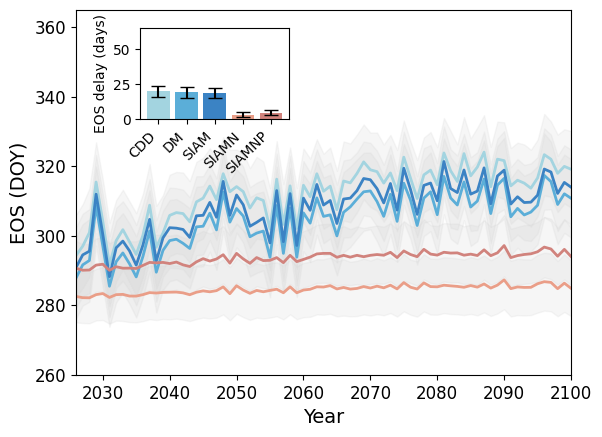

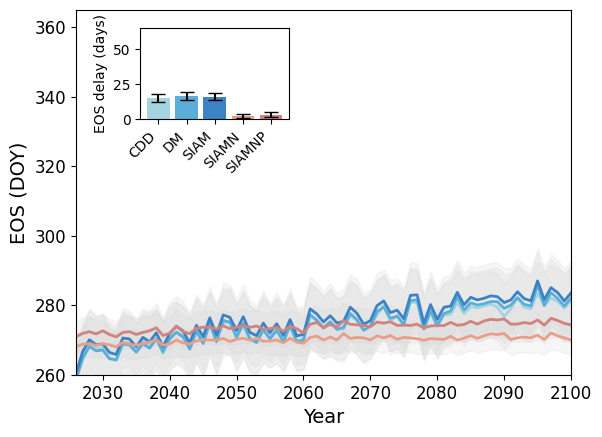

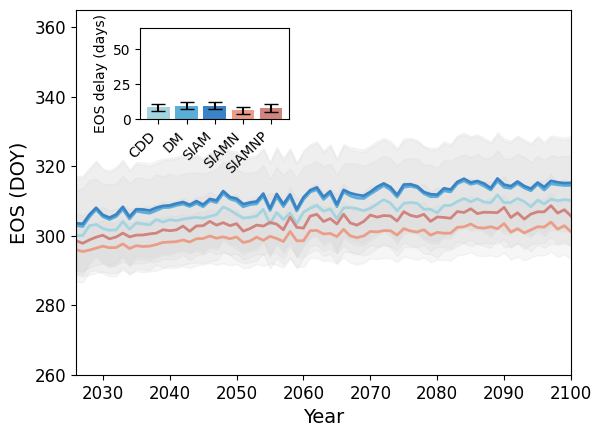

In [12]:
## Plot Fig. S8 (a,b,c)
data_list_ssp245 = merge_t_p(eos_projection_ssp245)
hot_dry = [d for d in data_list_ssp245 if d['annual_p'] < 0.9 and d['annual_t'] > 7.25]
cold_dry = [d for d in data_list_ssp245 if d['annual_p'] < 0.9 and d['annual_t'] < 7.25]
wet = [d for d in data_list_ssp245 if d['annual_p'] > 0.9]
fig = plot_eos_trend(hot_dry, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp245_all_models_hot_dry.png", dpi=300, bbox_inches='tight')
fig = plot_eos_trend(cold_dry, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp245_all_models_cold_dry.png", dpi=300, bbox_inches='tight')
fig = plot_eos_trend(wet, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp245_all_models_wet.png", dpi=300, bbox_inches='tight')

EOS delays by 2100 [np.float64(46.13148148148148), np.float64(52.49897119341563), np.float64(50.685390946502054), np.float64(11.234979423868312), np.float64(14.52119341563786)]
EOS delays by 2100 [np.float64(44.99532037437005), np.float64(54.91427285817135), np.float64(52.768250539956796), np.float64(10.718052555795536), np.float64(14.238534917206621)]
EOS delays by 2100 [np.float64(22.488465298142717), np.float64(26.538318670576736), np.float64(26.01436950146628), np.float64(21.89485174323884), np.float64(25.172825024437927)]


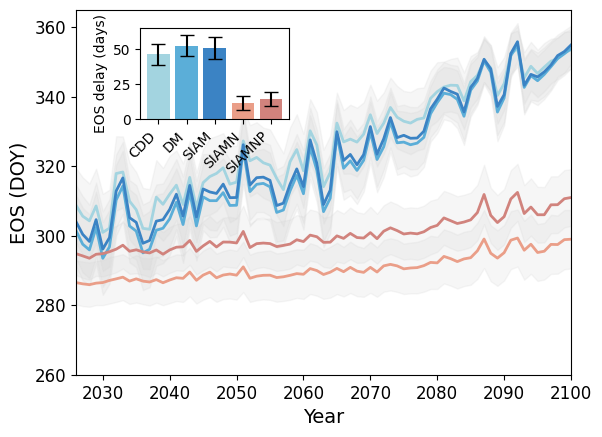

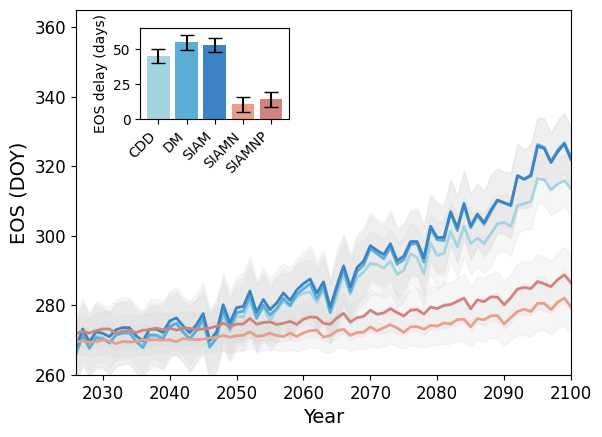

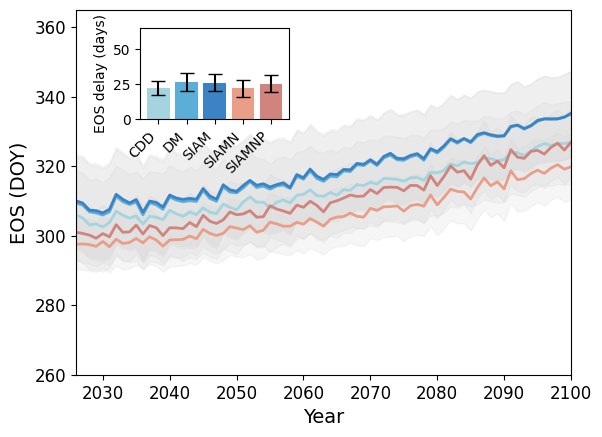

In [13]:
## Plot Fig. S8 (d,e,f)
data_list_ssp585 = merge_t_p(eos_projection_ssp585)
hot_dry = [d for d in data_list_ssp585 if d['annual_p'] < 0.9 and d['annual_t'] > 7.25]
cold_dry = [d for d in data_list_ssp585 if d['annual_p'] < 0.9 and d['annual_t'] < 7.25]
wet = [d for d in data_list_ssp585 if d['annual_p'] > 0.9]
fig = plot_eos_trend(hot_dry, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp585_all_models_hot_dry.png", dpi=300, bbox_inches='tight')
fig = plot_eos_trend(cold_dry, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp585_all_models_cold_dry.png", dpi=300, bbox_inches='tight')
fig = plot_eos_trend(wet, start_year, end_year)
fig.savefig(f"../results/si_figures/si_fig8/ssp585_all_models_wet.png", dpi=300, bbox_inches='tight')